In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
import warnings
warnings.filterwarnings('ignore')

## Part1: Data Exploration

### Part 1.1: Understand the Raw Dataset

In [2]:
mobile_df = pd.read_csv('train.csv') #has 2000

In [3]:
mobile_df.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


In [4]:
mobile_df.tail()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
1995,794,1,0.5,1,0,1,2,0.8,106,6,...,1222,1890,668,13,4,19,1,1,0,0
1996,1965,1,2.6,1,0,0,39,0.2,187,4,...,915,1965,2032,11,10,16,1,1,1,2
1997,1911,0,0.9,1,1,1,36,0.7,108,8,...,868,1632,3057,9,1,5,1,1,0,3
1998,1512,0,0.9,0,4,1,46,0.1,145,5,...,336,670,869,18,10,19,1,1,1,0
1999,510,1,2.0,1,5,1,45,0.9,168,6,...,483,754,3919,19,4,2,1,1,1,3


以下是新加的部分，是来处理异常值的，比如说10%的手机宽和像素宽是0，不make sense，但因为对用户来说都很重要，所以不能随意填充，还是删掉了

In [5]:
cnt1 = (mobile_df['sc_w']==0).sum()
cnt1

180

<AxesSubplot:>

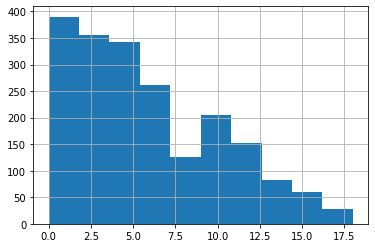

In [6]:
mobile_df['sc_w'].hist()

In [7]:
cnt2 = (mobile_df['px_height']==0).sum()
cnt2

2

<AxesSubplot:>

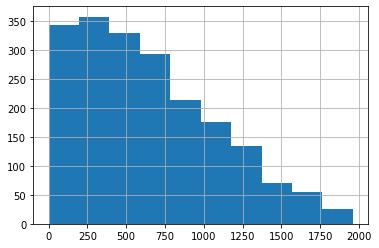

In [8]:
mobile_df['px_height'].hist()

In [9]:
mobile_df = mobile_df[(mobile_df.px_height != 0) & (mobile_df.sc_w != 0)].reset_index(drop = True)

In [10]:
mobile_df.info(verbose = True, memory_usage = 'deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1819 entries, 0 to 1818
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  1819 non-null   int64  
 1   blue           1819 non-null   int64  
 2   clock_speed    1819 non-null   float64
 3   dual_sim       1819 non-null   int64  
 4   fc             1819 non-null   int64  
 5   four_g         1819 non-null   int64  
 6   int_memory     1819 non-null   int64  
 7   m_dep          1819 non-null   float64
 8   mobile_wt      1819 non-null   int64  
 9   n_cores        1819 non-null   int64  
 10  pc             1819 non-null   int64  
 11  px_height      1819 non-null   int64  
 12  px_width       1819 non-null   int64  
 13  ram            1819 non-null   int64  
 14  sc_h           1819 non-null   int64  
 15  sc_w           1819 non-null   int64  
 16  talk_time      1819 non-null   int64  
 17  three_g        1819 non-null   int64  
 18  touch_sc

In [11]:
mobile_df.nunique()
#blue,dual_sim,four_g,three_g,touch_screen, wifi and price_range are all categorical
#they are all binary variables, no need to one-hot encoding

battery_power    1052
blue                2
clock_speed        26
dual_sim            2
fc                 20
four_g              2
int_memory         63
m_dep              10
mobile_wt         121
n_cores             8
pc                 21
px_height        1070
px_width         1056
ram              1455
sc_h               15
sc_w               18
talk_time          19
three_g             2
touch_screen        2
wifi                2
price_range         4
dtype: int64

In [12]:
#get target value
y = mobile_df['price_range']

### Part1.2: Understand the features

In [13]:
#check missing values
mobile_df.isnull().sum()

battery_power    0
blue             0
clock_speed      0
dual_sim         0
fc               0
four_g           0
int_memory       0
m_dep            0
mobile_wt        0
n_cores          0
pc               0
px_height        0
px_width         0
ram              0
sc_h             0
sc_w             0
talk_time        0
three_g          0
touch_screen     0
wifi             0
price_range      0
dtype: int64

In [14]:
#no duplicated data
mobile_df.duplicated().sum()

0

In [15]:
#Understand Numerical feature
mobile_df.describe()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
count,1819.000000,1819.000000,1819.000000,1819.000000,1819.000000,1819.000000,1819.000000,1819.000000,1819.000000,1819.000000,...,1819.000000,1819.000000,1819.000000,1819.000000,1819.000000,1819.000000,1819.000000,1819.000000,1819.000000,1819.000000
mean,1238.031336,0.503573,1.519406,0.504673,4.319956,0.524464,32.156130,0.499835,140.578340,4.531061,...,647.086861,1252.828477,2133.468939,12.488730,6.338098,11.009346,0.760858,0.507422,0.513469,1.509621
std,439.989288,0.500125,0.813975,0.500116,4.355982,0.499538,18.105723,0.288875,35.437231,2.288705,...,444.741154,432.418889,1087.488721,4.166008,4.153085,5.456642,0.426677,0.500082,0.499956,1.119529
min,501.000000,0.000000,0.500000,0.000000,0.000000,0.000000,2.000000,0.100000,80.000000,1.000000,...,1.000000,500.000000,256.000000,5.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000
25%,845.000000,0.000000,0.700000,0.000000,1.000000,0.000000,16.000000,0.200000,109.000000,3.000000,...,284.000000,877.000000,1203.500000,9.000000,3.000000,6.000000,1.000000,0.000000,0.000000,1.000000
50%,1231.000000,1.000000,1.500000,1.000000,3.000000,1.000000,32.000000,0.500000,141.000000,5.000000,...,562.000000,1251.000000,2175.000000,13.000000,6.000000,11.000000,1.000000,1.000000,1.000000,2.000000
75%,1611.000000,1.000000,2.200000,1.000000,7.000000,1.000000,48.000000,0.800000,170.500000,7.000000,...,952.000000,1633.000000,3072.500000,16.000000,9.000000,16.000000,1.000000,1.000000,1.000000,3.000000
max,1998.000000,1.000000,3.000000,1.000000,19.000000,1.000000,64.000000,1.000000,200.000000,8.000000,...,1960.000000,1998.000000,3998.000000,19.000000,18.000000,20.000000,1.000000,1.000000,1.000000,3.000000


In [16]:
#check the feature distribution
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
plt.style.use('ggplot')

<AxesSubplot:xlabel='price_range', ylabel='talk_time'>

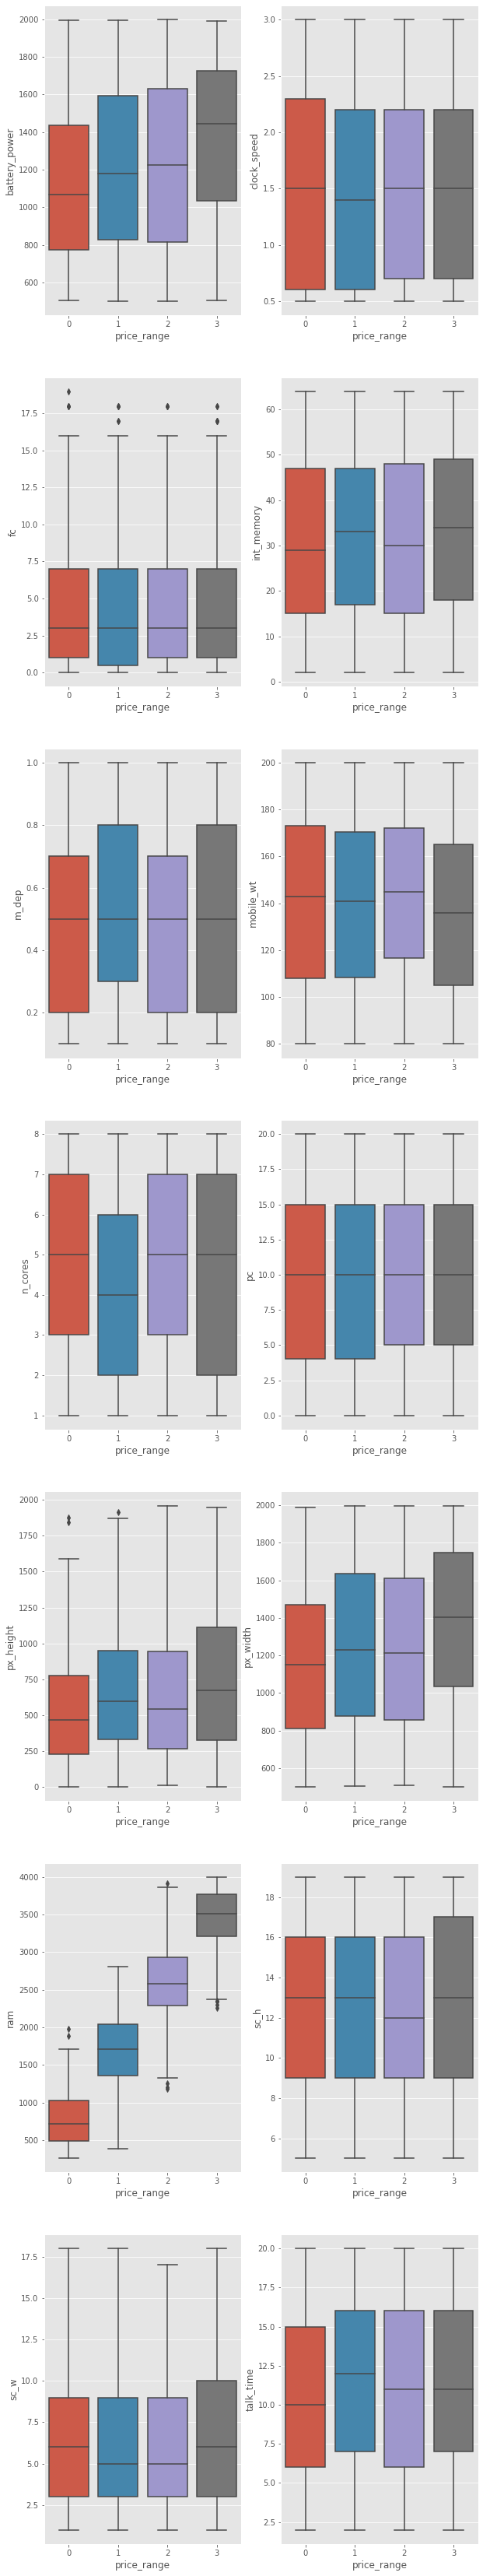

In [18]:
_,axes = plt.subplots(7,2,figsize = [10,60])
sns.boxplot(x = 'price_range', y = 'battery_power', data = mobile_df , ax= axes[0][0])#higher the better
sns.boxplot(x = 'price_range', y = 'clock_speed', data = mobile_df , ax= axes[0][1]) #doesn't seem to be correleated
sns.boxplot(x = 'price_range', y = 'fc',data = mobile_df , ax= axes[1][0]) #have outliers, doesn't seem to be correlated 
sns.boxplot(x = 'price_range', y = 'int_memory',data = mobile_df , ax= axes[1][1]) #doesn't seem to be correlated
sns.boxplot(x = 'price_range', y = 'm_dep',data = mobile_df , ax= axes[2][0]) #doesn't seem to be correlated
sns.boxplot(x = 'price_range', y = 'mobile_wt',data = mobile_df , ax= axes[2][1]) #doesn't seem to be correlated
sns.boxplot(x = 'price_range', y = 'n_cores',data = mobile_df , ax= axes[3][0]) # doesn't seem to be correlated
sns.boxplot(x = 'price_range', y = 'pc',data = mobile_df , ax= axes[3][1]) #seem to be positivey correlated
sns.boxplot(x = 'price_range', y = 'px_height',data = mobile_df , ax= axes[4][0]) # seen to be positively correlated
sns.boxplot(x = 'price_range', y = 'px_width',data = mobile_df , ax= axes[4][1]) #seem to be positively correlated
sns.boxplot(x = 'price_range', y = 'ram',data = mobile_df , ax= axes[5][0])  #higher the beter, exists outlier
sns.boxplot(x = 'price_range', y = 'sc_h',data = mobile_df , ax= axes[5][1]) #doesn't seem to be correlated
sns.boxplot(x = 'price_range', y = 'sc_w',data = mobile_df , ax= axes[6][0]) #doesn't seem to be correlated
sns.boxplot(x = 'price_range', y = 'talk_time',data = mobile_df , ax= axes[6][1]) #doesn't seem to be correlated
 




<AxesSubplot:>

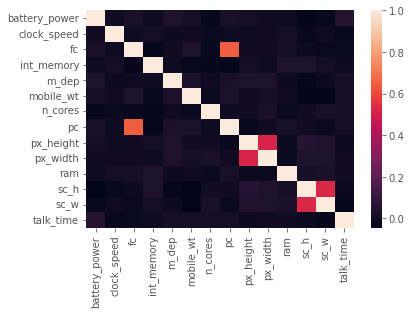

In [19]:
corr_score = mobile_df[['battery_power','clock_speed','fc','int_memory','m_dep','mobile_wt','n_cores',\
                       'pc','px_height','px_width','ram','sc_h','sc_w','talk_time']].corr()
sns.heatmap(corr_score)
#sc and fc, height and weight, which is expectable

In [20]:
corr_score = mobile_df[['fc','pc','px_height','px_width','sc_h','sc_w']].corr()
corr_score


,fc,pc,px_height,px_width,sc_h,sc_w
fc,1.000000,0.645880,-0.001558,-0.004116,-0.012501,-0.017689
pc,0.645880,1.000000,-0.021050,-0.004242,0.000101,-0.019056
px_height,-0.001558,-0.021050,1.000000,0.514228,0.060553,0.043699
px_width,-0.004116,-0.004242,0.514228,1.000000,0.033194,0.035759
sc_h,-0.012501,0.000101,0.060553,0.033194,1.000000,0.524451
sc_w,-0.017689,-0.019056,0.043699,0.035759,0.524451,1.000000


<AxesSubplot:xlabel='price_range', ylabel='count'>

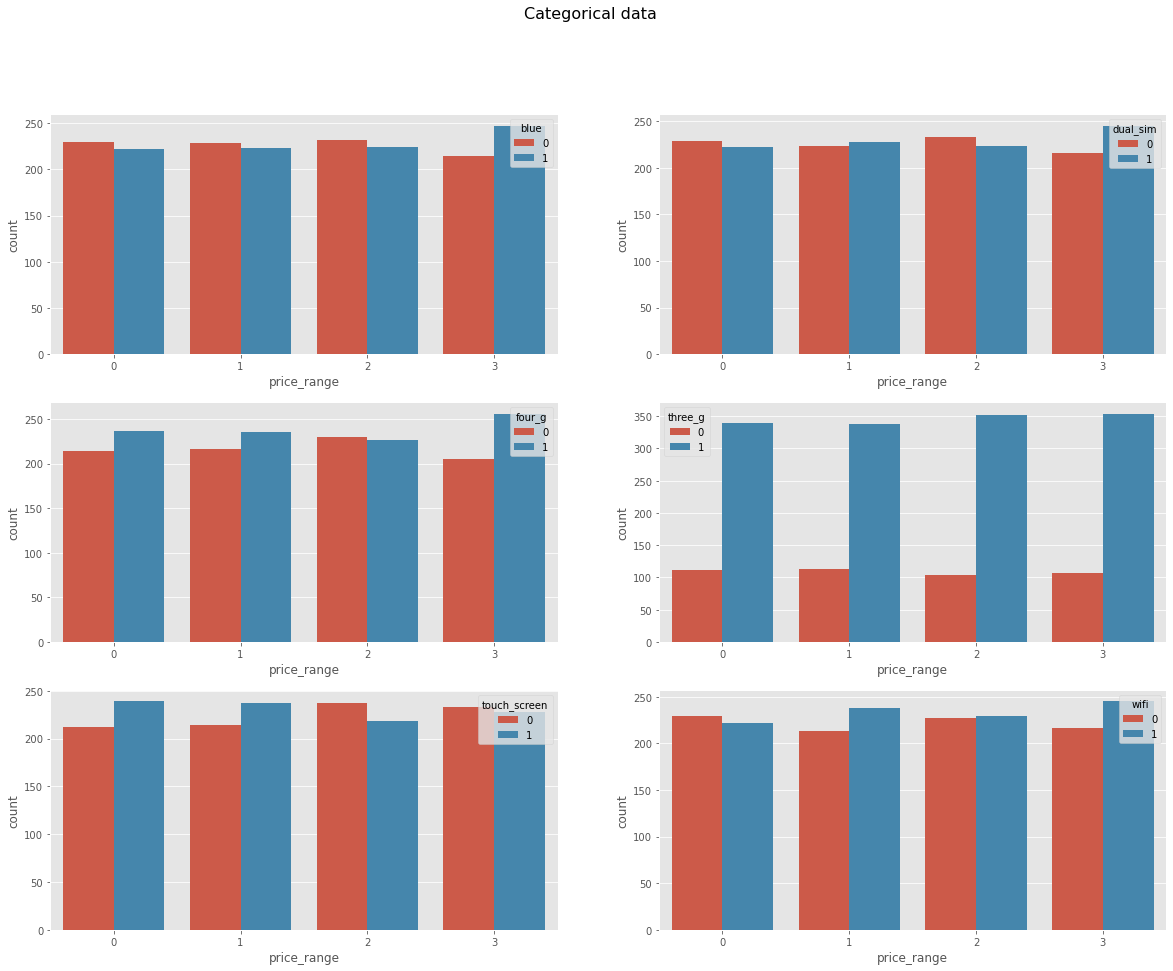

In [21]:
#now understand cateforical feature
#blue,dual_sim,four_g,three_g,touch_screen, wifi and price_range are all categorical
fig,axes = plt.subplots(3,2,figsize = [20,15])
fig.suptitle('Categorical data', fontsize=16)
sns.countplot(x = 'price_range', hue = 'blue', data = mobile_df, ax = axes[0][0])
sns.countplot(x = 'price_range', hue = 'dual_sim', data = mobile_df, ax = axes[0][1])
sns.countplot(x = 'price_range', hue = 'four_g', data = mobile_df, ax = axes[1][0])
sns.countplot(x = 'price_range', hue = 'three_g', data = mobile_df, ax = axes[1][1])
sns.countplot(x = 'price_range', hue = 'touch_screen', data = mobile_df, ax = axes[2][0])
sns.countplot(x = 'price_range', hue = 'wifi', data = mobile_df, ax = axes[2][1])
#bluttooth, dual_sim,four_g  and wifi seems to all favour the mobile pirce to some extent

<AxesSubplot:xlabel='ram', ylabel='Density'>

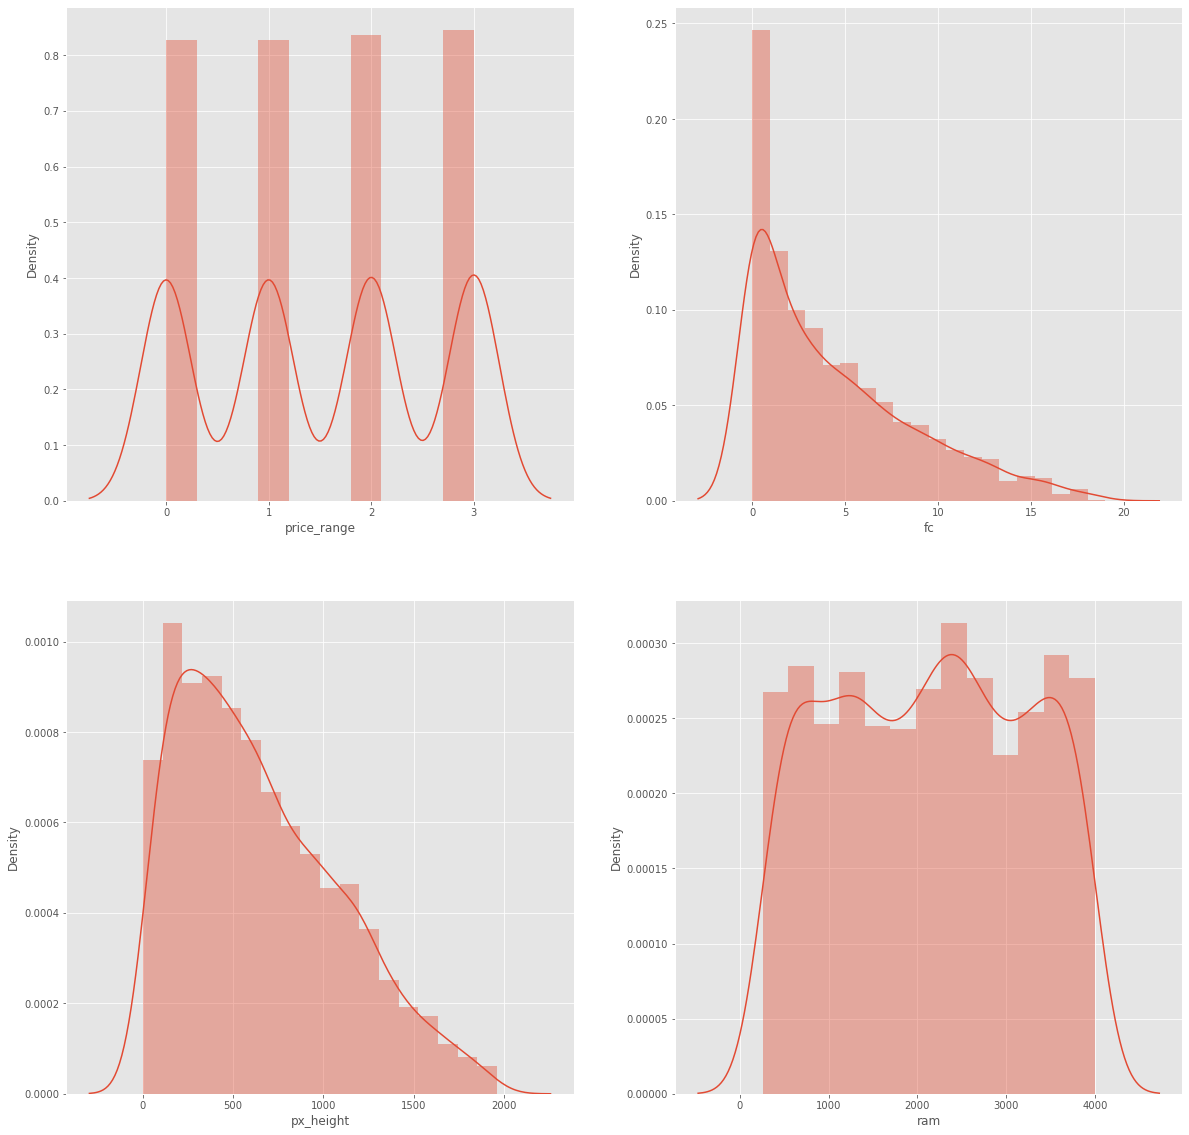

In [22]:
#Check distribution and outlier if we witness outlier point in the previous box plots.
_,axes = plt.subplots(2,2,figsize = [20,20])
sns.distplot(mobile_df.price_range, ax= axes[0][0])#higher the better
sns.distplot(mobile_df.fc, ax= axes[0][1]) #doesn't seem to be correleated
sns.distplot(mobile_df.px_height, ax= axes[1][0]) #have outliers, doesn't seem to be correlated 
sns.distplot(mobile_df.ram, ax= axes[1][1]) #doesn't seem to be correlated

#From the graph we don't think there is a need to handel outlier

## Part 2: Feature Preprocessing

### Part 2.1: Split DataSet

In [23]:
to_drop = ['price_range']
X = mobile_df.drop(to_drop, axis = 1)

In [24]:
cat_cols = X.columns[X.nunique() == 2]
num_cols = X.columns[X.nunique() != 2]

In [25]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y,test_size = 0.25, stratify = y, random_state = 1) #stratified sampling

print('training data has ' + str(X_train.shape[0]) + ' observation with ' + str(X_train.shape[1]) + ' features')
print('test data has ' + str(X_test.shape[0]) + ' observation with ' + str(X_test.shape[1]) + ' features')

training data has 1364 observation with 20 features
test data has 455 observation with 20 features


In [26]:
X_train_r = X_train.copy()
X_test_r = X_test.copy()
y_train_r = y_train.copy()
y_test_r = y_test.copy()

### Part 2.2: Featrue selection

In [27]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

def cal_evaluation(classifier,cm):
    tn = cm[0][0]
    tp = cm[1][1]
    fp = cm[0][1]
    fn = cm[1][0]
    accuracy = (tp + tn)/ (tp + fp + fn + tn + 0.0)
    precision = tp/ (tp + fp + 0.0)
    recall = tp / (tp + fn + 0.0)
    print(classifier)
    print('Accuracy is: ' + str(accuracy))
    print('Precision is: ' + str(precision))
    print('Recall is: ' + str(recall))
    print()
    
    
def draw_confusion_matrices(confusion_matrices):
    for cm in confusion_matrices:
        classifier,cm = cm[0],cm[1]
        cal_evaluation(classifier,cm)


In [28]:
def draw_mae_v1(model_name,X,y):
    mae_train = []
    mae_test = []
    kf = KFold(n_splits=10)
    for train_index, test_index in kf.split(X):
        Xtrain, Xtest = X.iloc[train_index], X.iloc[test_index]
        ytrain, ytest = y[train_index], y[test_index]
        model = model_name
        model.fit(Xtrain, ytrain)
        y_train_pred = model.predict(Xtrain)
        y_test_pred = model.predict(Xtest)
        mae_train.append(mean_absolute_error(ytrain, y_train_pred))
        mae_test.append(mean_absolute_error(ytest, y_test_pred))
    plt.figure(figsize=(6,4))
    plt.plot(mae_train, 'o-', color='green', label='train')
    plt.plot(mae_test, 'o-', color='red', label='test')
    plt.legend()
    plt.grid()
    plt.title(f"{model_name}")
    plt.xlabel('Number of fold')
    plt.ylabel('Mean Absolute Error')
    plt.show()
    
def draw_mae_v2(model_name,X,y):
    mae_train = []
    mae_test = []
    kf = KFold(n_splits=10)
    for train_index, test_index in kf.split(X):
        Xtrain, Xtest = X.iloc[train_index], X.iloc[test_index]
        ytrain, ytest = y[train_index], y[test_index]
        model = model_name
        y_train_pred = model.predict(Xtrain)
        y_test_pred = model.predict(Xtest)
        mae_train.append(mean_absolute_error(ytrain, y_train_pred))
        mae_test.append(mean_absolute_error(ytest, y_test_pred))
    plt.figure(figsize=(6,4))
    plt.plot(mae_train, 'o-', color='green', label='train')
    plt.plot(mae_test, 'o-', color='red', label='test')
    plt.legend()
    plt.grid()
    
    plt.title(f"{model_name}")
    plt.xlabel('Number of fold')
    plt.ylabel('Mean Absolute Error')
    plt.show()

In [29]:
#L1
# For L1, remove feature with 0 coff


X_2 = X.copy()
scaler = StandardScaler()
X_l1 = scaler.fit_transform(X_2)
for k in range(4):
    print(f'for price_range: {k}')
    for i in range(1,11):
        LRmodel_l1 = LogisticRegression(penalty = 'l1', C = i/10,solver = 'liblinear', random_state = 1)
        LRmodel_l1.fit(X_l1,y)
        indicies = np.argsort(abs(LRmodel_l1.coef_[0]))[::-1]
        print("Logistic Regression (L1) Coeffients\n")
        print("C is {}".format(i/10))
        for ind in range(X_2.shape[1]):
            print("{0} : {1}".format(X_2.columns[indicies[ind]], round(LRmodel_l1.coef_[k][indicies[ind]], 4)))



for price_range: 0
Logistic Regression (L1) Coeffients

C is 0.1
ram : -5.7344
battery_power : -1.2833
px_height : -0.8581
px_width : -0.6748
mobile_wt : 0.023
int_memory : -0.0144
m_dep : 0.0
blue : 0.0
clock_speed : 0.0
dual_sim : 0.0
fc : 0.0
four_g : 0.0
wifi : 0.0
touch_screen : 0.0
pc : 0.0
sc_h : 0.0
sc_w : 0.0
talk_time : 0.0
three_g : 0.0
n_cores : 0.0
Logistic Regression (L1) Coeffients

C is 0.2
ram : -7.8982
battery_power : -1.8422
px_height : -1.1979
px_width : -1.0016
mobile_wt : 0.1371
int_memory : -0.0793
m_dep : -0.027
dual_sim : 0.0243
clock_speed : 0.0199
sc_w : 0.0119
blue : 0.0
fc : 0.0
four_g : 0.0
wifi : 0.0
touch_screen : 0.0
pc : 0.0
sc_h : 0.0
talk_time : 0.0
three_g : 0.0
n_cores : 0.0
Logistic Regression (L1) Coeffients

C is 0.3
ram : -9.5044
battery_power : -2.2454
px_height : -1.4518
px_width : -1.2357
mobile_wt : 0.2147
int_memory : -0.113
m_dep : -0.0514
dual_sim : 0.0401
sc_w : 0.0381
clock_speed : 0.0332
three_g : 0.0256
wifi : 0.0015
touch_screen : 0

Logistic Regression (L1) Coeffients

C is 0.7
ram : 0.5992
battery_power : -0.0186
px_height : 0.0155
px_width : -0.0811
mobile_wt : 0.1378
int_memory : -0.0769
three_g : 0.0999
wifi : -0.0372
sc_w : 0.0066
m_dep : -0.0414
dual_sim : -0.0693
blue : -0.0427
talk_time : -0.0162
touch_screen : -0.0557
clock_speed : 0.0137
pc : -0.0145
sc_h : -0.0881
four_g : -0.1375
fc : 0.0391
n_cores : 0.1016
Logistic Regression (L1) Coeffients

C is 0.8
ram : 0.6002
battery_power : -0.0191
px_height : 0.0168
px_width : -0.0823
mobile_wt : 0.1385
int_memory : -0.0775
three_g : 0.1011
wifi : -0.0379
sc_w : 0.0077
m_dep : -0.042
talk_time : -0.0167
dual_sim : -0.0699
blue : -0.0433
touch_screen : -0.0563
clock_speed : 0.0143
pc : -0.0161
sc_h : -0.0894
four_g : -0.1387
fc : 0.0406
n_cores : 0.1023
Logistic Regression (L1) Coeffients

C is 0.9
ram : 0.601
battery_power : -0.0196
px_height : 0.0178
px_width : -0.0833
mobile_wt : 0.139
int_memory : -0.0779
three_g : 0.1021
wifi : -0.0384
sc_w : 0.0085
talk_t

Logistic Regression (L1) Coeffients


for price_range: 0


ram : -9.5044
battery_power : -2.2454
px_height : -1.4518
px_width : -1.2357
mobile_wt : 0.2147
int_memory : -0.113
m_dep : -0.0514
dual_sim : 0.0401
sc_w : 0.0381
clock_speed : 0.0332
three_g : 0.0256
wifi : 0.0015
touch_screen : 0.0
pc : 0.0
four_g : 0.0
fc : 0.0
sc_h : 0.0
talk_time : 0.0
blue : 0.0
n_cores : 0.0


for price_range: 1


ram : -0.5631
n_cores : -0.1269
talk_time : 0.0933
m_dep : 0.0837
battery_power : -0.0634
px_height : 0.0597
clock_speed : -0.0576
sc_w : -0.0443
wifi : 0.0406
int_memory : 0.0329
touch_screen : 0.0229
dual_sim : 0.0205
px_width : -0.0165
three_g : -0.0097
sc_h : 0.0
pc : 0.0
mobile_wt : 0.0
four_g : 0.0
fc : 0.0
blue : 0.0


for price_range: 2


ram : 0.5886
mobile_wt : 0.1312
four_g : -0.1243
n_cores : 0.0945
three_g : 0.0866
sc_h : -0.078
int_memory : -0.0707
px_width : -0.0683
dual_sim : -0.0629
touch_screen : -0.0492
blue : -0.0364
m_dep : -0.0352
wifi : -0.0305
fc : 0.0245
battery_power 

<AxesSubplot:>

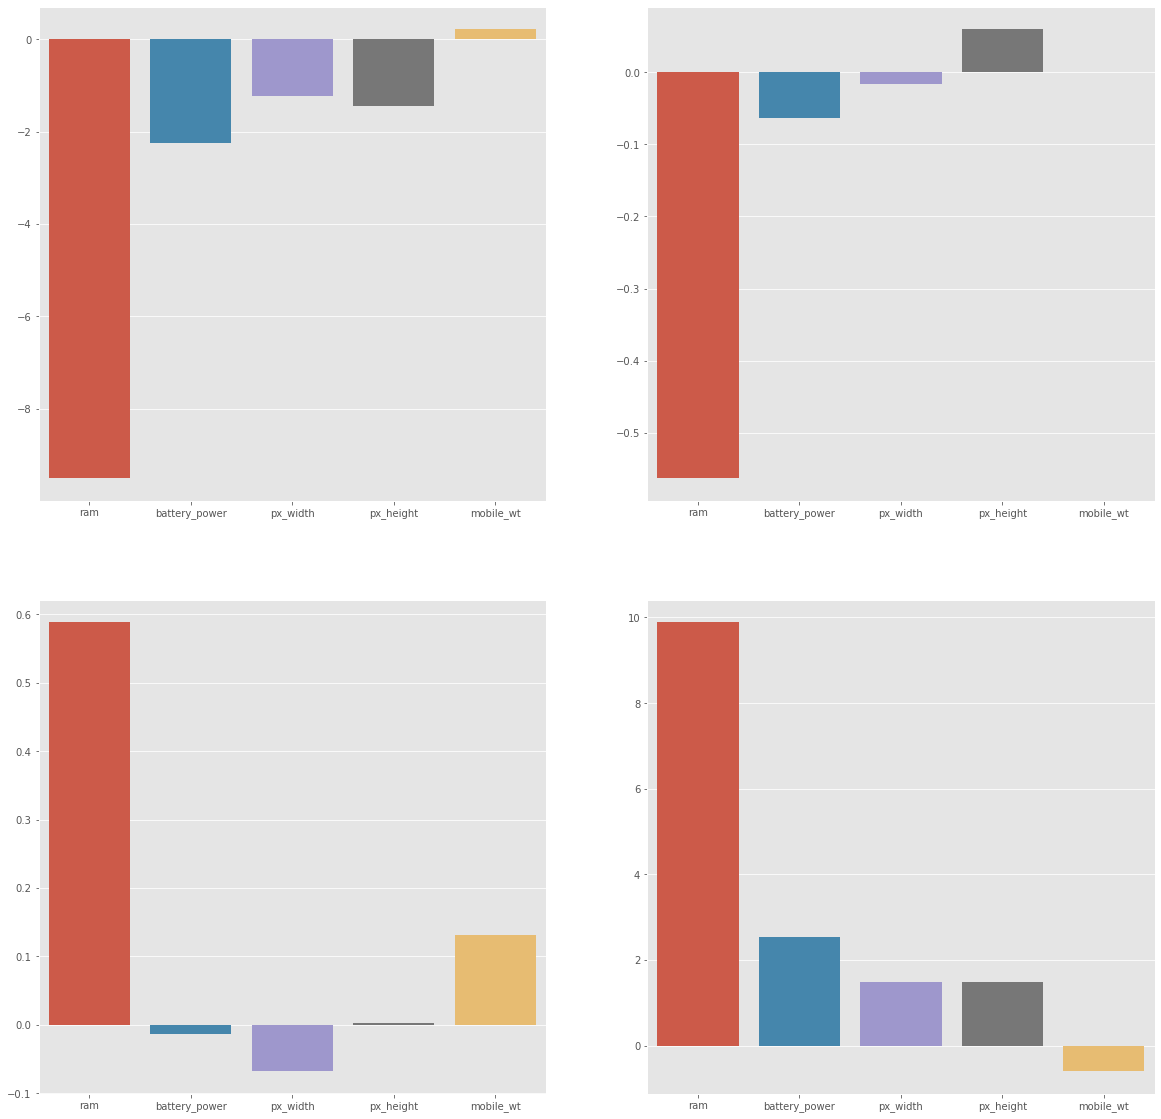

In [30]:
LRmodel_l1 = LogisticRegression(penalty = 'l1', C = 0.3,solver = 'liblinear', random_state = 1)
LRmodel_l1.fit(X_l1,y)

#indicies = np.argsort(abs(LRmodel_l1.coef_[0]))[::-1]

print("Logistic Regression (L1) Coeffients")
for k in range(4):
    print('\n')
    print(f"for price_range: {k}")
    print('\n')
    indicies = np.argsort(abs(LRmodel_l1.coef_[k]))[::-1]
    for ind in range(X_2.shape[1]):
        print("{0} : {1}".format(X_2.columns[indicies[ind]], round(LRmodel_l1.coef_[k][indicies[ind]], 4)))

#fig,ax = plt.subplots(4,1)
#for k in range(4):
#    plt.bar(X_2.columns[indicies[range(5)]],LRmodel_l1.coef_[k][indicies[range(5)]],axe = ax[])
    
_,axes = plt.subplots(2,2,figsize = [20,20])
sns.barplot(X_2.columns[indicies[range(5)]],LRmodel_l1.coef_[0][indicies[range(5)]], ax= axes[0][0])
sns.barplot(X_2.columns[indicies[range(5)]],LRmodel_l1.coef_[1][indicies[range(5)]], ax= axes[0][1]) 
sns.barplot(X_2.columns[indicies[range(5)]],LRmodel_l1.coef_[2][indicies[range(5)]], ax= axes[1][0]) 
sns.barplot(X_2.columns[indicies[range(5)]],LRmodel_l1.coef_[3][indicies[range(5)]], ax= axes[1][1]) 


In [31]:
#L2
X_2 = X.copy()
scaler = StandardScaler()
X_l2 = scaler.fit_transform(X_2)
LRmodel_l2 = LogisticRegression(penalty = 'l2', C = 0.1, solver = 'liblinear', random_state = 1)
LRmodel_l2.fit(X_l1,y)

indicies = np.argsort(abs(LRmodel_l2.coef_[0]))[::-1]

print("Logistic Regression (L2) Coeffients")
for ind in range(X_2.shape[1]):
    print("{0} : {1}".format(X_2.columns[indicies[ind]], round(LRmodel_l2.coef_[0][indicies[ind]], 4)))

Logistic Regression (L2) Coeffients
ram : -3.4755
battery_power : -0.8228
px_height : -0.5854
px_width : -0.4554
int_memory : -0.093
clock_speed : 0.084
n_cores : 0.0824
mobile_wt : 0.0801
m_dep : -0.0742
sc_w : 0.0688
talk_time : -0.06
dual_sim : 0.0461
touch_screen : 0.0385
fc : -0.038
four_g : -0.0305
sc_h : -0.0262
three_g : 0.0256
pc : 0.0255
blue : 0.0135
wifi : -0.0116


<AxesSubplot:>

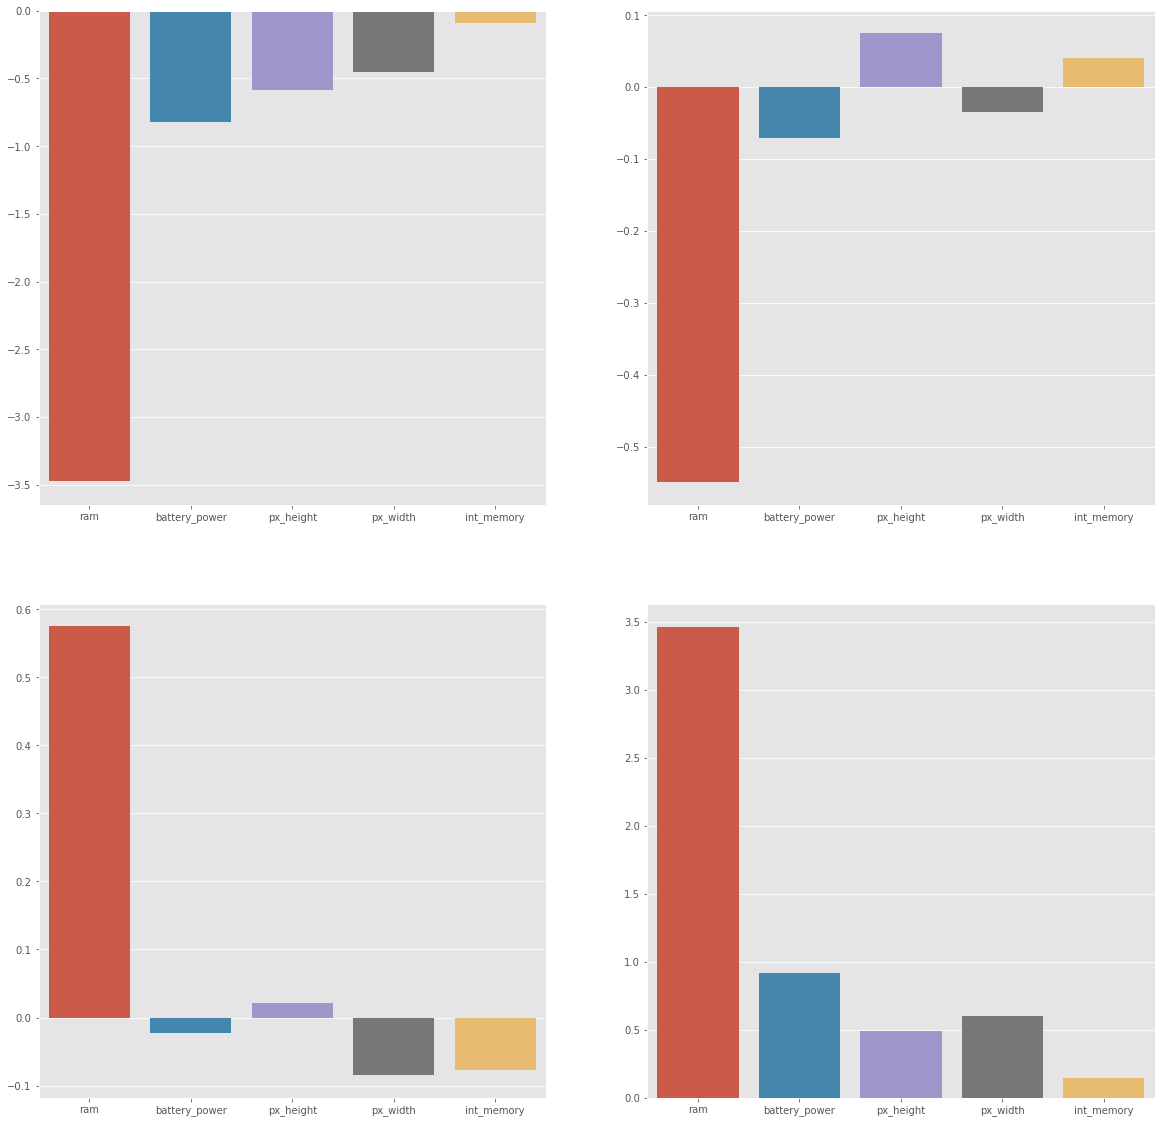

In [32]:
_,axes = plt.subplots(2,2,figsize = [20,20])
sns.barplot(X_2.columns[indicies[range(5)]],LRmodel_l2.coef_[0][indicies[range(5)]], ax= axes[0][0])
sns.barplot(X_2.columns[indicies[range(5)]],LRmodel_l2.coef_[1][indicies[range(5)]], ax= axes[0][1]) 
sns.barplot(X_2.columns[indicies[range(5)]],LRmodel_l2.coef_[2][indicies[range(5)]], ax= axes[1][0]) 
sns.barplot(X_2.columns[indicies[range(5)]],LRmodel_l2.coef_[3][indicies[range(5)]], ax= axes[1][1]) 

Feature importance ranking by Random Forest Model: 
ram : 0.4797
battery_power : 0.0715
px_height : 0.0588
px_width : 0.0564
mobile_wt : 0.0408
int_memory : 0.0365
talk_time : 0.0299
pc : 0.0294
clock_speed : 0.0292
sc_h : 0.0283
sc_w : 0.0276
m_dep : 0.0254
fc : 0.0242
n_cores : 0.0223
touch_screen : 0.0071
blue : 0.0071
dual_sim : 0.0071
wifi : 0.0065
four_g : 0.0064
three_g : 0.0059


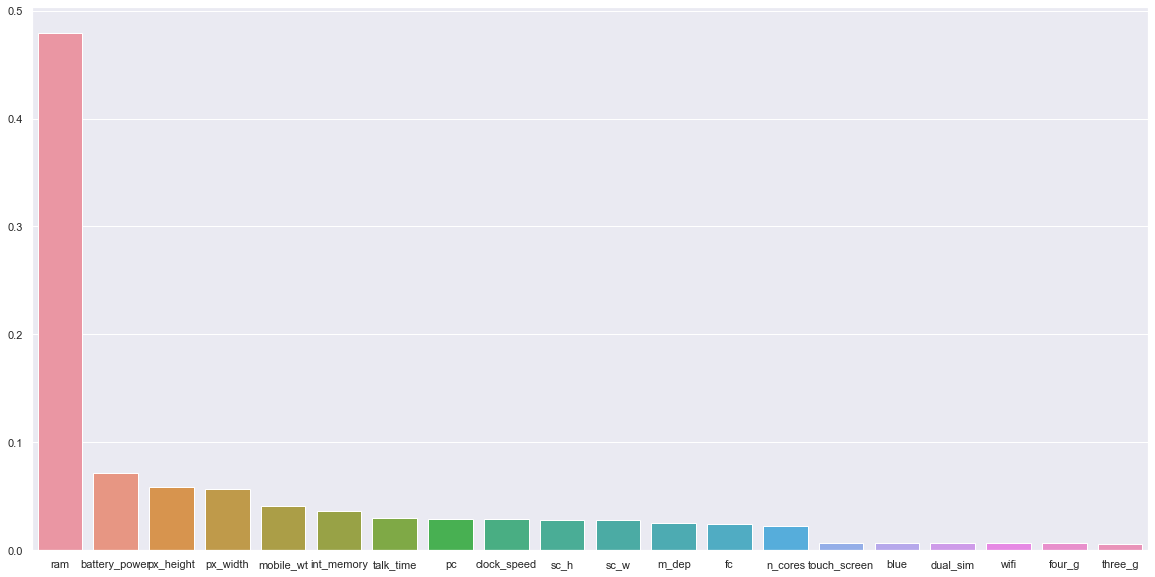

In [33]:
X_RF = X.copy()
forest = RandomForestClassifier()
forest.fit(X_RF,y)

importances = forest.feature_importances_

indicies = np.argsort(importances)[::-1]

print("Feature importance ranking by Random Forest Model: ")
for ind in range(X.shape[1]):
    print("{0} : {1}".format(X_RF.columns[indicies[ind]], round(importances[indicies[ind]],4)))
sns.set(rc={'figure.figsize':(20,10)})
sns.barplot(X_RF.columns[indicies[range(X.shape[1])]], importances[indicies[range(X.shape[1])]]);

<Figure size 1600x1600 with 0 Axes>

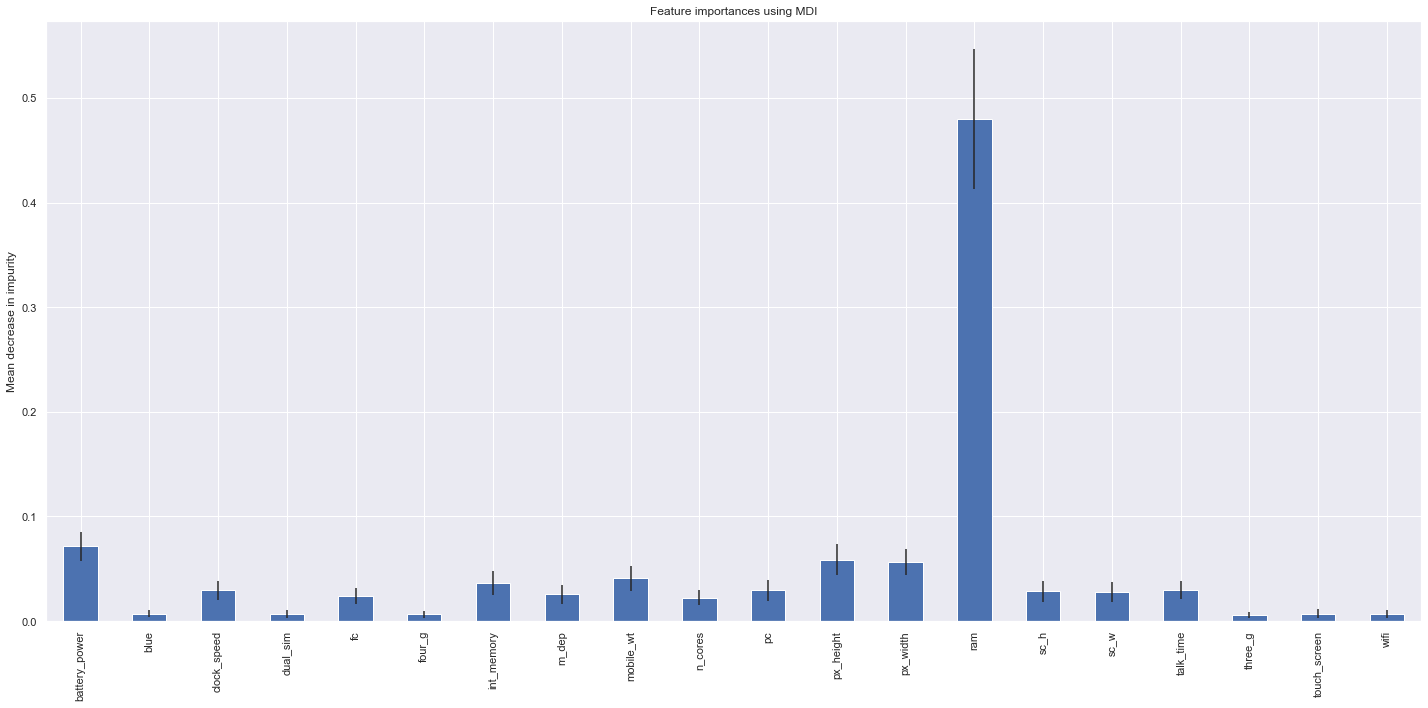

In [34]:
from matplotlib.pyplot import figure

figure(figsize=(20, 20), dpi=80)
importances = forest.feature_importances_

forest_importances = pd.Series(importances,index=X_RF.columns)
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr = std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [35]:
#Logistic Regression
classifier_logistic = LogisticRegression()

#K Nearest Neighbots
classifier_KNN = KNeighborsClassifier()

#Random Forest
classifier_RF = RandomForestClassifier()


In [36]:
#Use k-fold Cross Validation to get the accuracy for different models
model_names = ['Logistic Regression', 'KNN' , 'Random Forest']
model_list = [classifier_logistic, classifier_KNN, classifier_RF]


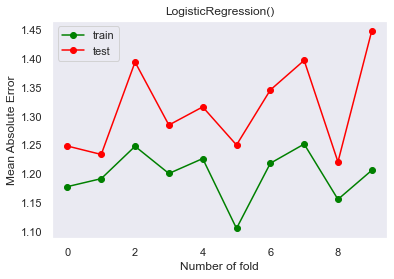

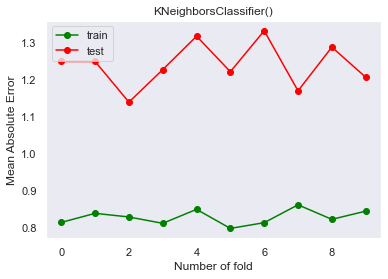

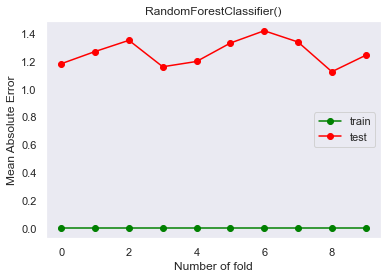

In [37]:
for i in model_list: 
    draw_mae_v1(i,X_train,y)

In [38]:
X_logistic= X.copy()
X_logistic['sc_area'] = X_logistic['sc_h'] * X_logistic['sc_w']
X_logistic.drop(columns = ['fc','pc','dual_sim','sc_h','sc_w','blue','wifi','three_g','four_g','touch_screen','talk_time'],inplace = True)


X_logistic_train = X_train.copy()
X_logistic_train['sc_area'] = X_logistic_train['sc_h'] * X_logistic_train['sc_w']
X_logistic_train.drop(columns = ['fc','pc','dual_sim','sc_h','sc_w','blue','wifi','three_g','four_g','touch_screen','talk_time'],inplace = True)
X_logistic_test = X_test.copy()
X_logistic_test['sc_area'] = X_logistic_test['sc_h'] * X_logistic_test['sc_w']
X_logistic_test.drop(columns = ['fc','pc','dual_sim','sc_h','sc_w','blue','wifi','three_g','four_g','touch_screen','talk_time'],inplace = True)

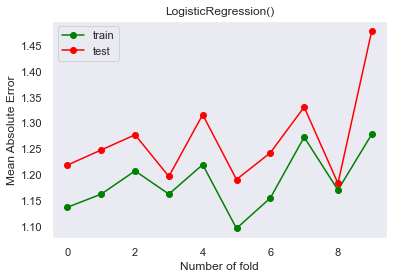

In [39]:
draw_mae_v1(model_list[0],X_logistic_train,y)
#less overfitting

In [40]:
X_rf_train = X_train.copy()
X_rf_train.drop(columns = ['three_g','four_g','blue','dual_sim','touch_screen','wifi','n_cores','fc'],inplace = True)
X_rf_test = X_test.copy()
X_rf_test.drop(columns = ['three_g','four_g','blue','dual_sim','touch_screen','wifi','n_cores','fc'],inplace = True)

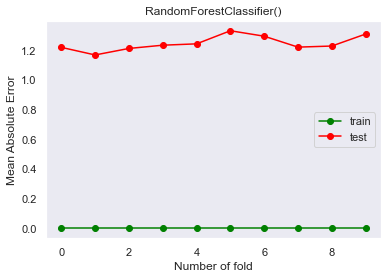

In [41]:
draw_mae_v1(model_list[2],X_rf_train,y)
#doesn't change 

In [42]:
X_knn_train = X_train.copy()
X_knn_train['sc_area'] = X_knn_train['sc_h'] * X_knn_train['sc_w']
X_knn_train.drop(columns = ['sc_h','sc_w'],inplace = True)
X_knn_test = X_test.copy()
X_knn_test['sc_area'] = X_knn_test['sc_h'] * X_knn_test['sc_w']
X_knn_test.drop(columns = ['sc_h','sc_w'],inplace = True)

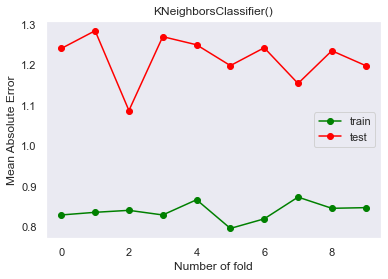

In [43]:
draw_mae_v1(model_list[1],X_knn_train,y)
#Didn't change. 

### Part 2.3 Standardize or not

In [44]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train[num_cols])
X_train[num_cols] = scaler.transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])


X_logistic_train_s = X_train.copy()
X_rf_train_s = X_train.copy()
X_knn_train_s = X_train.copy()


X_logistic_test_s = X_test.copy()
X_rf_test_s = X_test.copy()
X_knn_test_s = X_test.copy()



X_logistic_train_s = X_train.copy()
X_logistic_train_s['sc_area'] = X_logistic_train_s['sc_h'] * X_logistic_train_s['sc_w']
X_logistic_train_s.drop(columns = ['fc','pc','dual_sim','sc_h','sc_w','blue','wifi','three_g','four_g','touch_screen','talk_time'],inplace = True)
X_logistic_test_s = X_test.copy()
X_logistic_test_s['sc_area'] = X_logistic_test_s['sc_h'] * X_logistic_test_s['sc_w']
X_logistic_test_s.drop(columns = ['fc','pc','dual_sim','sc_h','sc_w','blue','wifi','three_g','four_g','touch_screen','talk_time'],inplace = True)


X_rf_train_s = X_train.copy()
X_rf_train_s.drop(columns = ['three_g','four_g','blue','dual_sim','touch_screen','wifi','n_cores','fc'],inplace = True)
X_rf_test_s = X_test.copy()
X_rf_test_s.drop(columns = ['three_g','four_g','blue','dual_sim','touch_screen','wifi','n_cores','fc'],inplace = True)


X_knn_train_s = X_train.copy()
X_knn_train_s['sc_area'] = X_knn_train_s['sc_h'] * X_knn_train_s['sc_w']
X_knn_train_s.drop(columns = ['sc_h','sc_w'],inplace = True)
X_knn_test_s = X_test.copy()
X_knn_test_s['sc_area'] = X_knn_test_s['sc_h'] * X_knn_test_s['sc_w']
X_knn_test_s.drop(columns = ['sc_h','sc_w'],inplace = True)

X_logistic = X.copy()
X_knn = X.copy()
X_rf = X.copy()
X_s = X.copy()


X_logistic['sc_area'] = X_logistic['sc_h'] * X_logistic['sc_w']
X_logistic.drop(columns = ['fc','pc','dual_sim','sc_h','sc_w','blue','wifi','three_g','four_g','touch_screen','talk_time'],inplace = True)

X_knn['sc_area'] = X_knn['sc_h'] * X_knn['sc_w']
X_knn.drop(columns = ['sc_h','sc_w'],inplace = True)

X_rf.drop(columns = ['three_g','four_g','blue','dual_sim','touch_screen','wifi','n_cores','fc'],inplace = True)



X_s[num_cols] = scaler.transform(X_s[num_cols])


X_logistic_s = X_s.copy()
X_logistic_s['sc_area'] = X_logistic_s['sc_h'] * X_logistic_s['sc_w']
X_logistic_s.drop(columns = ['fc','pc','dual_sim','sc_h','sc_w','blue','wifi','three_g','four_g','touch_screen','talk_time'],inplace = True)

X_knn_s = X_s.copy()
X_knn_s['sc_area'] = X_knn_s['sc_h'] * X_knn_s['sc_w']
X_knn_s.drop(columns = ['sc_h','sc_w'],inplace = True)

X_rf_s = X_s.copy()
X_rf_s.drop(columns = ['three_g','four_g','blue','dual_sim','touch_screen','wifi','n_cores','fc'],inplace = True)

[0.63736264 0.6043956  0.6043956  0.63369963 0.63235294]
Model accuracy of Logistic Regression is 0.6224412842059901
[0.8974359  0.92307692 0.91575092 0.90842491 0.90808824]
Model accuracy of KNN is 0.9105553759965523
[0.86446886 0.87545788 0.89010989 0.85347985 0.88970588]
Model accuracy of Random Forest is 0.8746444731738849


[Text(0, 0, '0.622441'), Text(0, 0, '0.910555'), Text(0, 0, '0.874644')]

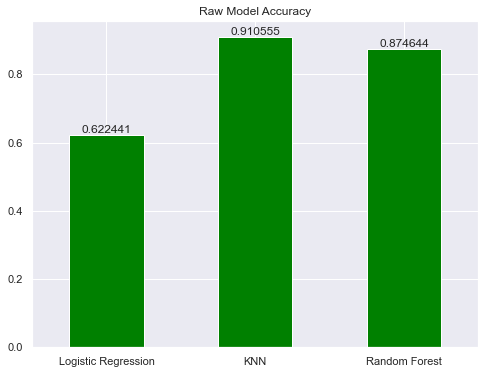

In [45]:
model_names = ['Logistic Regression', 'KNN' , 'Random Forest']
model_list = [classifier_logistic, classifier_KNN, classifier_RF]
model_data = [X_logistic_train,X_knn_train,X_rf_train]
count = 0
model_score_raw = []

for i in range(3):
    cv_score = model_selection.cross_val_score(model_list[i], model_data[i], y_train_r, cv = 5)
    print(cv_score)
    print('Model accuracy of ' + model_names[count] + ' is ' + str(cv_score.mean()))
    model_score_raw.append(cv_score.mean())
    count += 1

    
score_raw = pd.Series(model_score_raw, index = model_names)
plot = score_raw.plot.bar(x= "index", y="score_raw", rot = 0, figsize = (8,6), color = 'green')
plot.set_title('Raw Model Accuracy')
plot.bar_label(plot.containers[0])

[0.94139194 0.94139194 0.95238095 0.96336996 0.99264706]
Model accuracy of Logistic Regression is 0.9582363714716656
[0.6043956  0.59340659 0.55311355 0.64102564 0.56985294]
Model accuracy of KNN is 0.5923588666235725
[0.86080586 0.87179487 0.89010989 0.86080586 0.89705882]
Model accuracy of Random Forest is 0.8761150614091792


[Text(0, 0, '0.958236'), Text(0, 0, '0.592359'), Text(0, 0, '0.876115')]

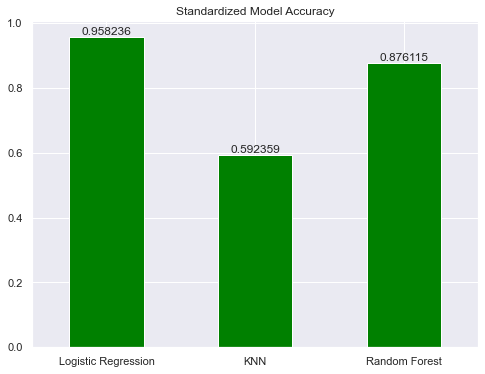

In [46]:
model_names = ['Logistic Regression', 'KNN' , 'Random Forest']
model_list = [classifier_logistic, classifier_KNN, classifier_RF]
model_data = [X_logistic_train_s,X_knn_train_s,X_rf_train_s]
count = 0
model_score_raw = []

for i in range(3):
    cv_score = model_selection.cross_val_score(model_list[i], model_data[i], y_train_r, cv = 5)
    print(cv_score)
    print('Model accuracy of ' + model_names[i] + ' is ' + str(cv_score.mean()))
    model_score_raw.append(cv_score.mean())

    
score_raw = pd.Series(model_score_raw, index = model_names)
plot = score_raw.plot.bar(x= "index", y="score_raw", rot = 0, figsize = (8,6), color = 'green')
plot.set_title('Standardized Model Accuracy')
plot.bar_label(plot.containers[0])

Conclusion: KNN and Random Forest use raw data, Logistic Regression use standardized data

In [47]:
X_logistic_train = X_logistic_train_s
X_logistic_test = X_logistic_test_s
X_logistic = X_logistic_s

## Part 3: Model Traing and Result Evaluation

### Part 3.1: Grid Search to Find Optimal Hyperparameters

In [48]:
from sklearn.model_selection import GridSearchCV

def print_grid_search_metrics(gs):
    print("Best score: "+ str(gs.best_score_))
    print('Best parameters sets:')
    best_parameters = gs.best_params_
    for param_name in sorted(best_parameters.keys()):
        print(param_name + ":" + str(best_parameters[param_name]))

#### Part 3.3.1: Logistic Regression

In [49]:
parameters = {
    'penalty':('l1', 'l2'),
    'C':np.linspace(0,1,5)
}
Grid_LR = GridSearchCV(LogisticRegression(solver = 'liblinear'), parameters, cv=5)
Grid_LR.fit(X_logistic_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(solver='liblinear'),
             param_grid={'C': array([0.  , 0.25, 0.5 , 0.75, 1.  ]),
                         'penalty': ('l1', 'l2')})

In [50]:
print_grid_search_metrics(Grid_LR)

Best score: 0.8446186166774403
Best parameters sets:
C:1.0
penalty:l1


In [51]:
#best model
best_LR_model = Grid_LR.best_estimator_

In [52]:
best_LR_model.predict(X_logistic_test)

array([2, 2, 3, 3, 1, 2, 2, 1, 3, 3, 1, 0, 1, 2, 2, 2, 0, 3, 0, 0, 0, 0,
       0, 3, 1, 1, 0, 3, 1, 1, 3, 0, 1, 1, 2, 1, 0, 0, 2, 1, 0, 1, 3, 2,
       1, 3, 3, 1, 0, 3, 2, 3, 0, 2, 2, 3, 1, 2, 1, 3, 2, 2, 2, 0, 3, 1,
       0, 2, 0, 2, 2, 0, 1, 3, 3, 1, 0, 0, 0, 2, 0, 3, 3, 0, 2, 3, 3, 2,
       1, 1, 1, 2, 3, 1, 2, 3, 3, 0, 2, 1, 0, 0, 3, 0, 1, 0, 1, 3, 0, 3,
       3, 0, 2, 1, 2, 1, 0, 3, 0, 3, 3, 2, 3, 1, 2, 2, 1, 0, 3, 2, 3, 0,
       1, 1, 3, 0, 2, 2, 0, 3, 0, 3, 2, 2, 1, 3, 0, 1, 2, 2, 1, 1, 3, 0,
       2, 1, 0, 3, 2, 3, 3, 1, 0, 1, 0, 0, 1, 0, 0, 2, 3, 0, 0, 1, 2, 1,
       0, 3, 1, 1, 1, 3, 1, 1, 2, 1, 2, 1, 1, 3, 0, 3, 3, 1, 3, 0, 2, 2,
       1, 0, 3, 1, 1, 2, 3, 0, 0, 1, 3, 3, 0, 2, 3, 0, 2, 0, 3, 0, 3, 1,
       3, 2, 1, 3, 3, 3, 1, 3, 3, 0, 2, 0, 0, 0, 3, 1, 3, 2, 0, 0, 2, 0,
       3, 2, 2, 0, 3, 1, 0, 2, 0, 1, 3, 2, 1, 1, 0, 0, 2, 1, 3, 1, 3, 0,
       0, 1, 3, 0, 1, 3, 2, 2, 3, 3, 0, 1, 1, 0, 3, 2, 2, 3, 1, 1, 1, 1,
       3, 1, 2, 3, 0, 3, 1, 3, 3, 1, 3, 1, 3, 0, 1,

In [53]:
best_LR_model.score(X_logistic_test,y_test) #not underfitting, not overfitting, no obvious difference

0.8505494505494505

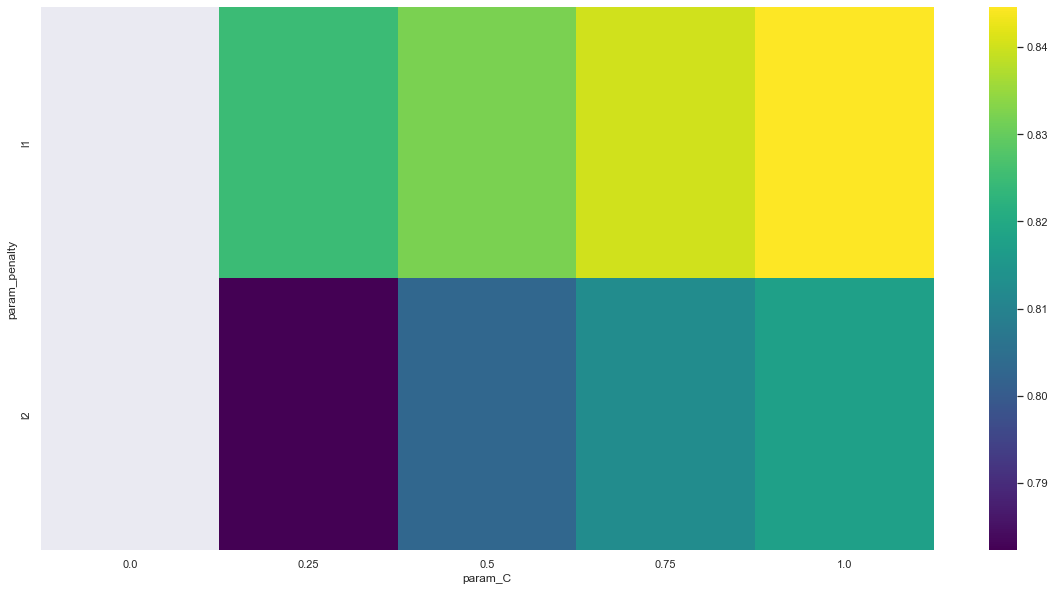

In [54]:
# L1 is better / L2 ; when C = 1.0
LR_models = pd.DataFrame(Grid_LR.cv_results_)
res = (LR_models.pivot(index = 'param_penalty', columns = 'param_C', values ='mean_test_score'))
_=sns.heatmap(res,cmap = 'viridis')

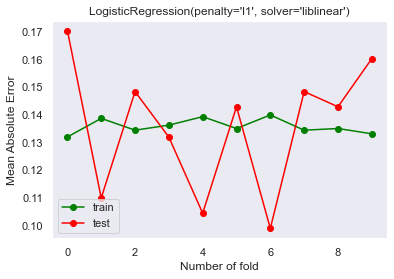

In [55]:
draw_mae_v2(best_LR_model, X_logistic, y)

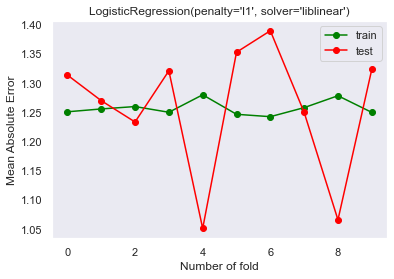

In [56]:
draw_mae_v2(best_LR_model, X_logistic_train, y)

In [57]:
X_logistic_train

,battery_power,clock_speed,int_memory,m_dep,mobile_wt,n_cores,px_height,px_width,ram,sc_area
985,0.226379,-0.485759,0.273074,0.680813,-0.415613,1.078425,1.042764,0.900587,0.019370,0.778847
408,0.133361,-0.733035,-0.386559,1.716074,1.057139,0.639198,0.277348,-0.800809,-1.008261,1.645821
589,-0.268208,-1.227586,1.152585,0.335726,-0.557224,-0.239256,-0.925124,-1.169675,1.381919,1.073425
1041,1.571748,-0.238483,-0.441529,1.716074,-1.548499,-0.239256,0.524184,0.040668,0.305789,0.886640
1281,1.685185,-1.227586,-0.606437,1.025900,-1.293600,1.517652,-1.167430,-1.704532,-0.385094,-0.106333
...,...,...,...,...,...,...,...,...,...,...
1277,-0.635746,-1.227586,1.262524,-1.389709,-0.472257,1.517652,-1.260276,1.002026,-0.768511,0.513749
1233,1.741904,-0.362121,-0.056743,0.335726,1.566938,1.517652,-1.341800,0.252766,0.152056,0.688368
1346,0.877510,1.368809,-0.166682,1.370987,-0.783801,0.639198,-0.814161,-1.314917,1.409372,-0.154401
1430,-1.137139,0.626982,-0.991223,0.335726,-0.160714,0.639198,-0.180089,-0.441164,1.145829,3.256153


#### Part 3.2.2 : KNN

In [58]:
# 因为在之前的section里已经发现了standardized dataset 并不合适random forest 和KNN， 
# 所以这里开始都用 X_train_r, X_test_r, y_test_r, y_train_r

In [59]:
parameters = {'n_neighbors': [i for i in range(1,45,2)]}
Grid_KNN =  GridSearchCV(KNeighborsClassifier(),parameters,cv=5)
Grid_KNN.fit(X_knn_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21,
                                         23, 25, 27, 29, 31, 33, 35, 37, 39, 41,
                                         43]})

In [60]:
print_grid_search_metrics(Grid_KNN)

Best score: 0.9288838612368024
Best parameters sets:
n_neighbors:11


In [61]:
best_KNN_model = Grid_KNN.best_estimator_

In [62]:
best_KNN_model.predict(X_knn_test)

array([2, 1, 3, 3, 2, 1, 2, 2, 3, 3, 1, 0, 1, 1, 1, 2, 0, 2, 0, 0, 0, 0,
       0, 3, 1, 1, 0, 3, 1, 1, 3, 0, 1, 1, 2, 1, 0, 0, 1, 2, 0, 2, 3, 2,
       1, 3, 3, 1, 0, 3, 1, 3, 0, 2, 2, 3, 1, 2, 1, 3, 2, 1, 2, 0, 3, 1,
       0, 2, 0, 2, 2, 0, 2, 3, 3, 1, 0, 1, 0, 2, 0, 3, 3, 0, 2, 3, 3, 2,
       1, 1, 1, 1, 3, 2, 2, 3, 2, 0, 2, 2, 0, 0, 3, 0, 1, 0, 1, 3, 0, 2,
       3, 0, 2, 1, 2, 1, 0, 2, 0, 3, 2, 1, 3, 1, 2, 2, 1, 0, 3, 2, 2, 0,
       1, 2, 3, 0, 2, 2, 0, 3, 0, 2, 2, 2, 1, 3, 0, 1, 2, 2, 2, 1, 2, 0,
       2, 1, 0, 3, 1, 3, 3, 1, 0, 1, 0, 0, 2, 0, 0, 2, 3, 0, 1, 1, 2, 1,
       0, 3, 1, 1, 1, 3, 1, 1, 1, 1, 2, 1, 1, 3, 0, 2, 2, 1, 3, 0, 2, 2,
       0, 0, 3, 1, 2, 2, 3, 0, 0, 1, 3, 3, 0, 2, 3, 0, 2, 1, 3, 0, 3, 1,
       3, 2, 1, 3, 3, 3, 1, 3, 3, 0, 2, 1, 0, 0, 3, 1, 3, 1, 0, 0, 2, 0,
       3, 2, 2, 0, 3, 2, 0, 2, 0, 1, 3, 2, 1, 1, 0, 0, 2, 1, 3, 1, 3, 0,
       0, 1, 3, 0, 1, 3, 3, 2, 3, 3, 0, 2, 1, 0, 3, 1, 2, 3, 1, 1, 1, 2,
       3, 1, 2, 3, 1, 2, 1, 3, 3, 2, 2, 1, 3, 0, 1,

In [63]:
best_KNN_model.score(X_knn_test,y_test)

0.9274725274725275

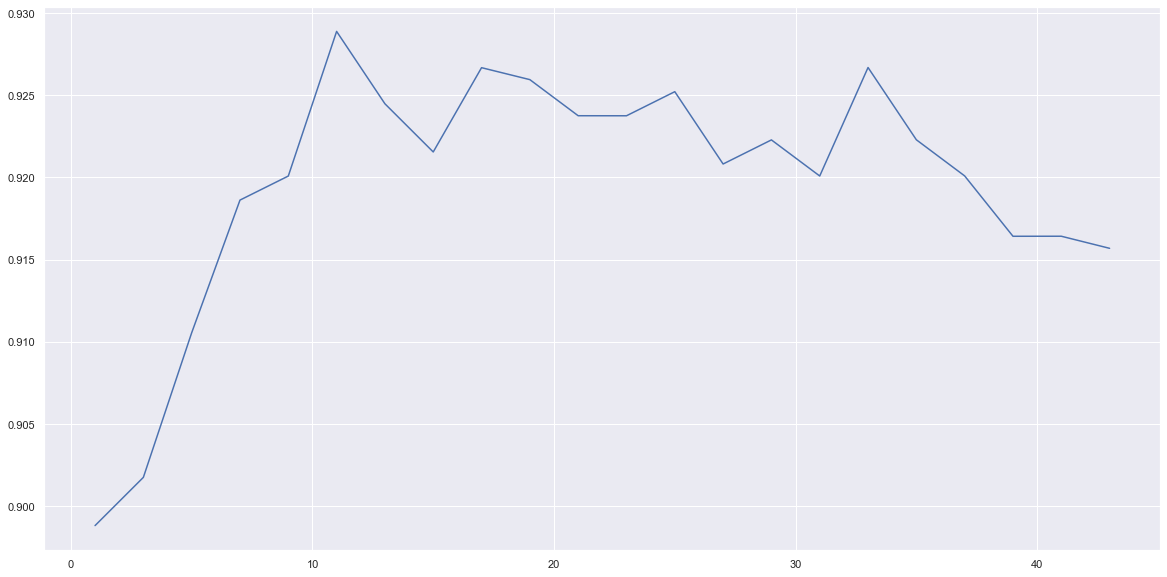

In [64]:
KNN_models = pd.DataFrame(Grid_KNN.cv_results_)
plt.plot(KNN_models['param_n_neighbors'],KNN_models['mean_test_score'])

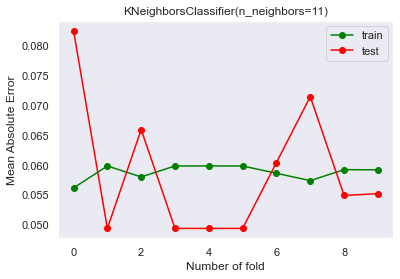

In [65]:
draw_mae_v2(best_KNN_model, X_knn, y)

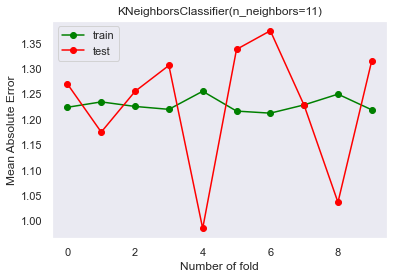

In [66]:
draw_mae_v2(best_KNN_model, X_knn_train, y)

#### Part 3.2.3 : Random Forest


In [67]:
parameters = { 
    'n_estimators': [60,80,100,200,500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [1,4,5,10],
    'criterion' :['gini', 'entropy']
}
Grid_RF =  GridSearchCV(RandomForestClassifier(),parameters,cv=5,verbose=True)
Grid_RF.fit(X_rf_train, y_train) # 用raw dataset 做！
X_train.columns

Fitting 5 folds for each of 120 candidates, totalling 600 fits


Index(['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g',
       'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height',
       'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'three_g',
       'touch_screen', 'wifi'],
      dtype='object')

In [68]:
print_grid_search_metrics(Grid_RF)

Best score: 0.8856334841628959
Best parameters sets:
criterion:entropy
max_depth:10
max_features:log2
n_estimators:100


In [69]:
best_RF_model = Grid_RF.best_estimator_

In [70]:
best_RF_model.predict(X_rf_test)

array([2, 1, 3, 3, 1, 2, 2, 2, 3, 3, 1, 0, 1, 1, 1, 2, 0, 2, 0, 0, 0, 0,
       0, 3, 1, 1, 0, 3, 1, 1, 3, 0, 1, 1, 2, 1, 0, 0, 2, 1, 0, 2, 3, 2,
       1, 3, 3, 1, 0, 3, 1, 3, 0, 2, 2, 3, 1, 2, 1, 3, 2, 1, 2, 0, 3, 1,
       0, 2, 0, 2, 2, 0, 2, 3, 3, 1, 0, 1, 0, 2, 0, 3, 3, 0, 2, 3, 3, 2,
       1, 1, 1, 1, 3, 1, 3, 3, 3, 0, 2, 2, 0, 0, 3, 0, 1, 0, 1, 3, 0, 3,
       3, 0, 2, 1, 2, 0, 0, 2, 0, 3, 2, 1, 3, 1, 2, 2, 1, 0, 3, 2, 3, 0,
       1, 2, 3, 0, 2, 2, 0, 3, 0, 3, 2, 2, 1, 3, 0, 1, 2, 2, 2, 1, 2, 0,
       2, 1, 0, 3, 1, 3, 3, 1, 0, 1, 0, 0, 2, 0, 0, 2, 3, 0, 0, 1, 2, 1,
       0, 3, 1, 1, 1, 3, 1, 1, 2, 1, 3, 1, 1, 3, 0, 3, 2, 1, 3, 1, 2, 3,
       0, 0, 3, 1, 2, 2, 3, 0, 0, 1, 3, 2, 0, 2, 3, 0, 3, 1, 3, 0, 3, 1,
       2, 2, 1, 3, 3, 3, 1, 3, 3, 0, 2, 1, 0, 0, 3, 0, 3, 2, 0, 0, 2, 0,
       3, 2, 2, 0, 3, 2, 0, 2, 0, 1, 3, 2, 1, 1, 0, 0, 2, 1, 3, 1, 3, 0,
       0, 1, 3, 0, 1, 3, 3, 2, 3, 3, 0, 1, 1, 0, 3, 1, 2, 3, 1, 1, 1, 2,
       3, 1, 2, 3, 0, 3, 1, 2, 3, 1, 3, 1, 2, 0, 1,

In [71]:
best_RF_model.score(X_rf_test,y_test)

0.8923076923076924

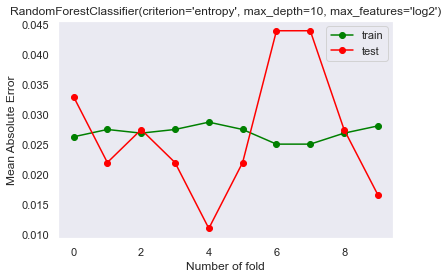

In [72]:
draw_mae_v2(best_RF_model, X_rf, y)

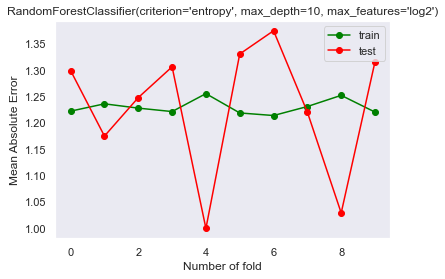

In [73]:
draw_mae_v2(best_RF_model, X_rf_train, y)

### Part 3.4: Confusion Matrix


In [74]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

def cal_evaluation(classifier,cm):
    tn = cm[0][0]
    tp = cm[1][1]
    fp = cm[0][1]
    fn = cm[1][0]
    accuracy = (tp + tn)/ (tp + fp + fn + tn + 0.0)
    precision = tp/ (tp + fp + 0.0)
    recall = tp / (tp + fn + 0.0)
    print(classifier)
    print('Accuracy is: ' + str(accuracy))
    print('Precision is: ' + str(precision))
    print('Recall is: ' + str(recall))
    print()
    
    
def draw_confusion_matrices(confusion_matrices):
    for cm in confusion_matrices:
        classifier,cm = cm[0],cm[1]
        cal_evaluation(classifier,cm)

In [75]:
## 这里 After 的 confusion matrix有变动：random forest和KNN都是用 没有standardized的dataset 去检验的

In [76]:
confusion_matrices_after = [
    ("After: Random Forest", confusion_matrix(y_test,best_RF_model.predict(X_rf_test))),
    ("After: Logistic Regression", confusion_matrix(y_test,best_LR_model.predict(X_logistic_test))),
    ("After : K nearest neighbor", confusion_matrix(y_test,best_KNN_model.predict(X_knn_test)))
]
draw_confusion_matrices(confusion_matrices_after)

## random forest 每次跑会有不一样 有的时候会比before的好 有的时候会比before的差， 
## 我的理解为因为每次slicing的不一样 会导致这 上下2%左右的浮动

After: Random Forest
Accuracy is: 0.958904109589041
Precision is: 0.9801980198019802
Recall is: 0.9339622641509434

After: Logistic Regression
Accuracy is: 0.9701492537313433
Precision is: 1.0
Recall is: 0.9318181818181818

After : K nearest neighbor
Accuracy is: 0.9555555555555556
Precision is: 0.9553571428571429
Recall is: 0.9553571428571429



Conclusion

Don't need to delete for random forest, just do hyperparameter tunning

For logistic, both score improvement and less overfitting

For KNN, just use the original data